<a href="https://colab.research.google.com/github/gabrielbklopes/GPS_Tracking_System/blob/main/PathSimulationKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path Simulation GPS

Developed by [Gabriel Lopes](https://)

The following program presents the simulation of a movement in a x-y plane using trigonometric functions. It's understandable that trigonometric functions aren't linear and the Kalman Filter implemented here is the linear model. That means this approach isn't the optimal one, but already presents good results. Understand that smaller is the filter sampling, better is the filter result, once that for a small debt the difference in acceleration isn't that high, which makes the filter understand the process more continuously. 

This cell presents the calculation for the process noise matrix. This code was by Labbe and the reference is presented in this link: https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python. 

In [ ]:
from scipy.linalg import expm, block_diag

def order_by_derivative(Q, dim, block_size):
    """
    Given a matrix Q, ordered assuming state space
        [x y z x' y' z' x'' y'' z''...]
    return a reordered matrix assuming an ordering of
       [ x x' x'' y y' y'' z z' y'']
    This works for any covariance matrix or state transition function
    Parameters
    ----------
    Q : np.array, square
        The matrix to reorder
    dim : int >= 1
       number of independent state variables. 3 for x, y, z
    block_size : int >= 0
        Size of derivatives. Second derivative would be a block size of 3
        (x, x', x'')
    """

    N = dim * block_size

    D = zeros((N, N))

    Q = array(Q)
    for i, x in enumerate(Q.ravel()):
        f = eye(block_size) * x

        ix, iy = (i // dim) * block_size, (i % dim) * block_size
        D[ix:ix+block_size, iy:iy+block_size] = f

    return 

def Q_discrete_white_noise(dim, dt=1., var=1., block_size=1, order_by_dim=True):
    """
    Returns the Q matrix for the Discrete Constant White Noise
    Model. dim may be either 2, 3, or 4 dt is the time step, and sigma
    is the variance in the noise.
    Q is computed as the G * G^T * variance, where G is the process noise per
    time step. In other words, G = [[.5dt^2][dt]]^T for the constant velocity
    model.
    Parameters
    -----------
    dim : int (2, 3, or 4)
        dimension for Q, where the final dimension is (dim x dim)
    dt : float, default=1.0
        time step in whatever units your filter is using for time. i.e. the
        amount of time between innovations
    var : float, default=1.0
        variance in the noise
    block_size : int >= 1
        If your state variable contains more than one dimension, such as
        a 3d constant velocity model [x x' y y' z z']^T, then Q must be
        a block diagonal matrix.
    order_by_dim : bool, default=True
        Defines ordering of variables in the state vector. `True` orders
        by keeping all derivatives of each dimensions)
        [x x' x'' y y' y'']
        whereas `False` interleaves the dimensions
        [x y z x' y' z' x'' y'' z'']
    Examples
    --------
    >>> # constant velocity model in a 3D world with a 10 Hz update rate
    >>> Q_discrete_white_noise(2, dt=0.1, var=1., block_size=3)
    array([[0.000025, 0.0005  , 0.      , 0.      , 0.      , 0.      ],
           [0.0005  , 0.01    , 0.      , 0.      , 0.      , 0.      ],
           [0.      , 0.      , 0.000025, 0.0005  , 0.      , 0.      ],
           [0.      , 0.      , 0.0005  , 0.01    , 0.      , 0.      ],
           [0.      , 0.      , 0.      , 0.      , 0.000025, 0.0005  ],
           [0.      , 0.      , 0.      , 0.      , 0.0005  , 0.01    ]])
    References
    ----------
    Bar-Shalom. "Estimation with Applications To Tracking and Navigation".
    John Wiley & Sons, 2001. Page 274.
    """

    if dim not in [2, 3, 4]:
        raise ValueError("dim must be between 2 and 4")

    if dim == 2:
        Q = [[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]]
    elif dim == 3:
        Q = [[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]]
    else:
        Q = [[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]]

    if order_by_dim:
        return block_diag(*[Q]*block_size) * var
    return order_by_derivative(array(Q), dim, block_size) * var

The cell below defines the functions to estimate the path. 
    x = 30*cos(0.0625*t)
    y = 30*sin(0.125*t)

There are 2 variables call losti (representing the beggining of a signal lost) and lostf (representing the end of a signal lost). Use them to simulate GPS signal lost. This code uses a compensation for signal lost using the acceleration.  

In [ ]:
import math
import numpy as np
from numpy.random import randn

count = 100
t = np.linspace(0, 32*math.pi, count)
dt = t[1] - t[0]
R_var_pos = 2
R_var_vel = 0.2
Q_var = 0.11
x_X = np.array([[30, 0]]).T
x_Y = np.array([[0, 0]]).T
P_X = np.diag([0.1, 0.1])
P_Y = np.diag([0.1, 0.1])
F = np.array([[1, dt],
              [0,  1]])
B = np.array([[(dt**2)/2, dt]]).T
H = np.array([[1., 0],
              [0, 1.]])

R = np.array([[R_var_pos**2, 0.],
             [0., R_var_vel]])
 
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)


losti = 35
lostf = 36

z_std_pos = (R_var_pos)
z_std_vel = (R_var_vel)
p_std = math.sqrt(Q_var)
xsa, ysa, zxs, zys = [], [], [], []
vxa, vya, zvx, zvy = [], [], [], []
axt, ayt = [], []
  
for i in range(count):

    x = 30*math.cos(0.0625*t[i])
    y = 30*math.sin(0.125*t[i])
    dxdt = -1.875*math.sin(0.0625*t[i])
    dydt = 3.75*math.cos(0.125*t[i])
    dx2dt2 = -0.1171875*math.cos(0.0625*t[i])
    dy2dt2 = -0.46875*math.sin(0.125*t[i])

    xsa.append(x)
    ysa.append(y)
    vxa.append(dxdt)
    vya.append(dydt)
    axt.append(dx2dt2 + randn() * Q_var)
    ayt.append(dy2dt2 + randn() * Q_var)

    
    if i>=losti and i<lostf:
      dxdt = (axt[i] - axt[i-1])*(t[i] - t[i-1]) + (vxa[i-1] + randn() * z_std_vel)  #-1.875*math.sin(0.0625*t[i])# + vxa[losti-1]
      #dxdt = (axt[i] - axt[i-1])*(dt) + (vxa[i-1] + randn() * z_std_vel)  #-1.875*math.sin(0.0625*t[i])# + vxa[losti-1]
      #dxdt = 0
      #vxa.append(dxdt)
      zvx.append(dxdt)# + randn() * z_std)
      dydt = (ayt[i] - ayt[i-1])*(t[i] - t[i-1]) + (vya[i-1] + randn() * z_std_vel)  #3.75*math.cos(0.125*t[i])# + vya[losti-1]
      #dydt = (ayt[i] - ayt[i-1])*(dt) + (vya[i-1] + randn() * z_std)  #3.75*math.cos(0.125*t[i])# + vya[losti-1]
      #dydt = 0
      #vya.append(dydt)
      zvy.append(dydt)# + randn() * z_std)
      #x = xsa[losti-1]
      #y = ysa[losti-1]
      #zxs.append(zxs[losti-1])
      #zys.append(zys[losti-1])
      #zvx.append(zvx[losti-1])
      #zvy.append(zvy[losti-1])     
      #dxdt = 0 #vxa[losti-1]
      #dydt = 0 #vya[losti-1]

      x = (vxa[i] - vxa[i-1])*(t[i] - t[i-1]) + (xsa[i-1] + randn() * z_std_pos)
      #x = (vxa[i] - vxa[i-1])*(dt) + (xsa[i-1] + randn() * z_std)
      #xsa.append(x)
      #x = zxs[i-1]
      y = (vya[i] - vya[i-1])*(t[i] - t[i-1]) + (ysa[i-1] + randn() * z_std_pos)
      #y = (vya[i] - vya[i-1])*(dt) + (ysa[i-1] + randn() * z_std)
      #ysa.append(y)
      #y = zys[i-1]
      zxs.append(x)# + randn() * z_std)
      zys.append(y)# + randn() * z_std)
      
    else:

      zxs.append(x + randn() * z_std_pos)
      zys.append(y  + randn() * z_std_pos)
      zvx.append(dxdt + randn() * z_std_vel)
      zvy.append(dydt + randn() * z_std_vel)     

xsa = np.array(xsa)
ysa = np.array(ysa)
vxa = np.array(vxa)
vya = np.array(vya)
zxs =  np.array(zxs)
zys = np.array(zys)
zvx =  np.array(zvx)
zvy = np.array(zvy)
axt = np.array(axt)
ayt = np.array(ayt)

j_var = max(np.var(axt), np.var(ayt))
print(j_var)



0.11819209832779089


Defines the Kalman Filter and plot the graphics.

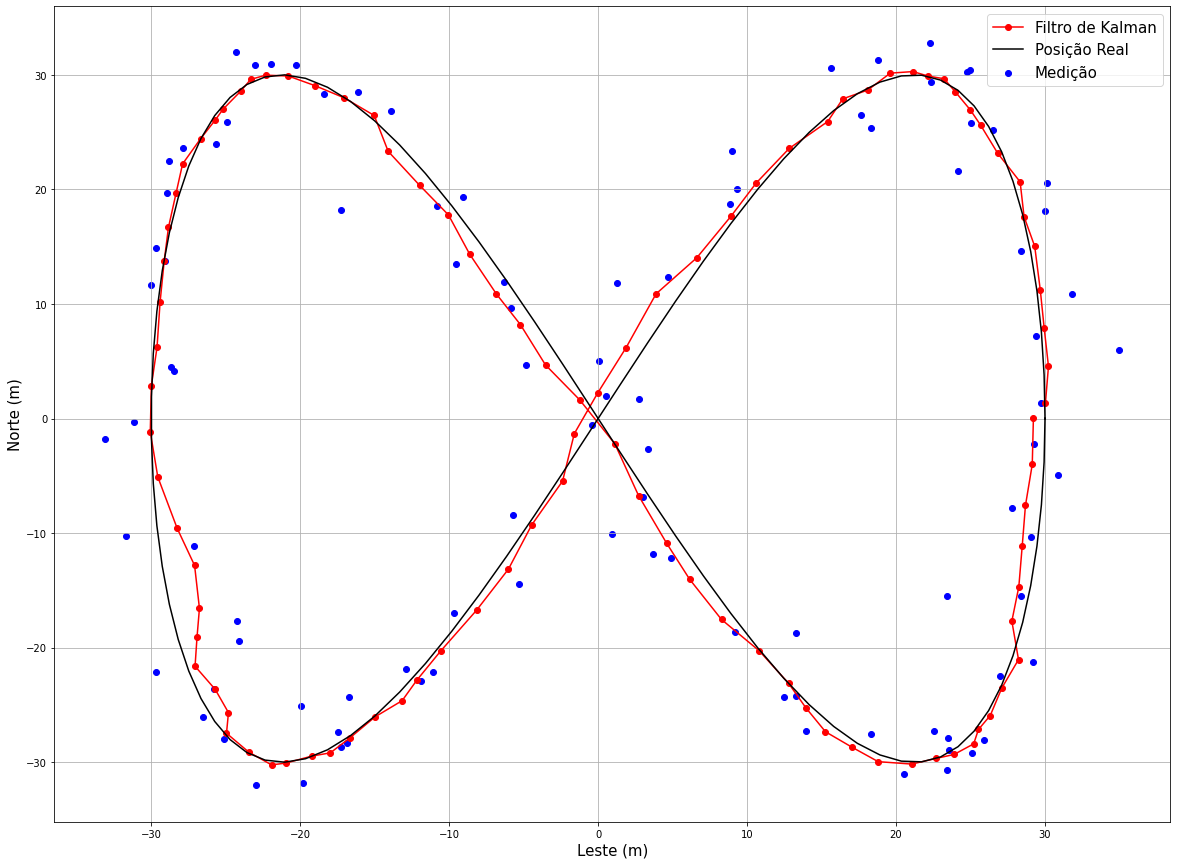

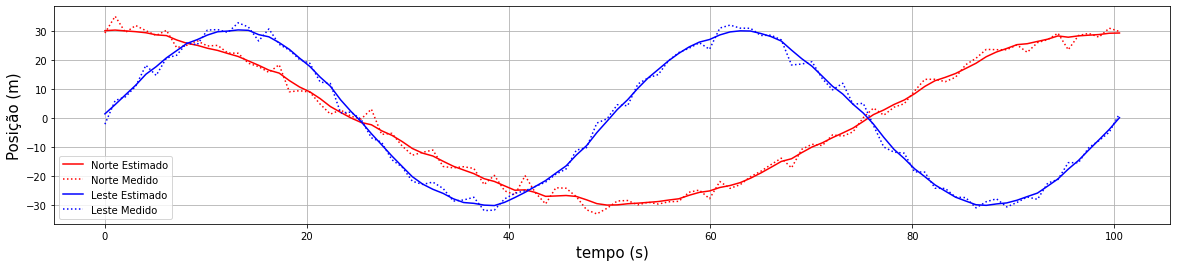

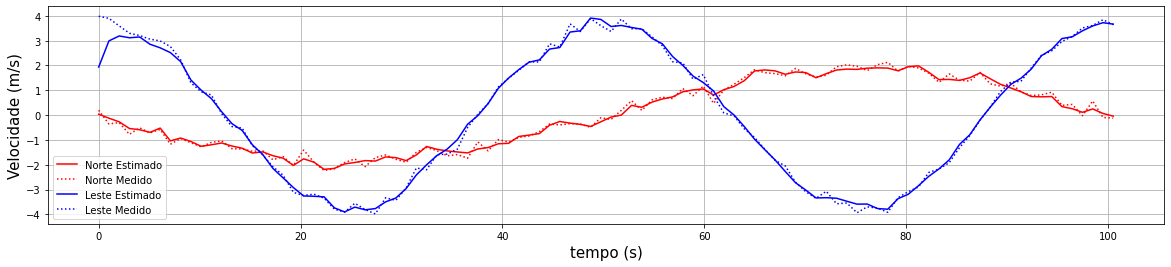

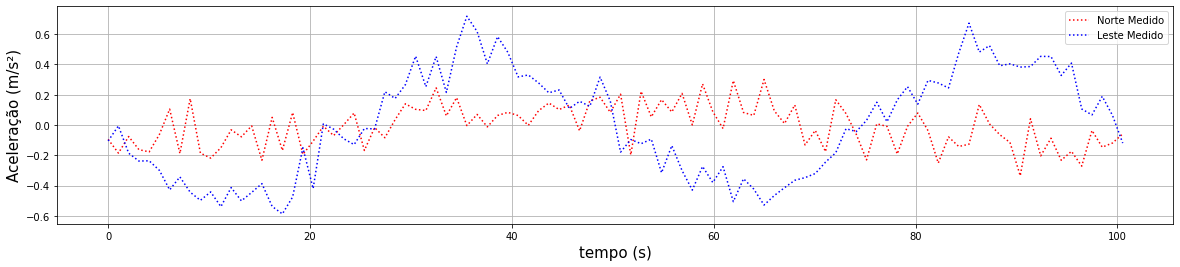

In [ ]:
from scipy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd

trackx = xsa
tracky = ysa

zx = np.column_stack((zxs, zvx))
zy = np.column_stack((zys, zvy))

xs, ys, covx, covy = [], [], [], []

i = 0
for z in zx:
  #predict
  x_X = F @ x_X + np.multiply(B, axt[i])
  P_X = F @ P_X @ F.T + Q

  #update
  S = H @ P_X @ H.T + R
  K = P_X @ H.T @ inv(S)
  y = z - (H @ x_X).T
  x_X += K @ y.T
  P_X = P_X - K @ H @ P_X

  xs.append(x_X)
  covx.append(P_X)

  i = i+1

i = 0
for z in zy:
  #predict
  x_Y = F @ x_Y + np.multiply(B, ayt[i])
  P_Y = F @ P_Y @ F.T + Q

  #update
  S = H @ P_Y @ H.T + R
  K = P_Y @ H.T @ inv(S)
  y = z - (H @ x_Y).T
  x_Y += K @ y.T
  P_Y = P_Y - K @ H @ P_Y

  ys.append(x_Y)
  covy.append(P_Y)
  i = i+1

xs, covx, ys, covy = np.array(xs), np.array(covx), np.array(ys), np.array(covy)

a_list = list(range(0,count))


MEDIUM_SIZE = 15
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
ax.plot(xs[:, 0], ys[:, 0], "o-",color="red", label='Filtro de Kalman')
ax.grid()
ax.scatter(zxs, zys,color="blue", label='Medição')
ax.plot(trackx, tracky, color="black", label='Posição Real')
leg = ax.legend(fontsize=15);
fig.set_figwidth(20)
fig.set_figheight(15)
plt.xlabel('Leste (m)')
plt.ylabel('Norte (m)')
plt.show()

fig,ax2 = plt.subplots()
ax2.grid()
ax2.plot(t[:], xs[:, 0], 'r-', label='Norte Estimado')
ax2.plot(t, zxs, 'r:', label='Norte Medido')
ax2.plot(t[:], ys[:, 0], 'b-', label='Leste Estimado')
ax2.plot(t, zys, 'b:', label='Leste Medido')
leg = ax2.legend(fontsize=10);
fig.set_figwidth(20)
plt.xlabel('tempo (s)')
plt.ylabel('Posição (m)')
plt.show()

fig,ax3 = plt.subplots()
ax3.grid()
ax3.plot(t, xs[:, 1], 'r-', label='Norte Estimado')
ax3.plot(t, zvx, 'r:', label='Norte Medido')
ax3.plot(t, ys[:, 1], 'b-', label='Leste Estimado')
ax3.plot(t, zvy, 'b:', label='Leste Medido')
leg = ax3.legend(fontsize=10);
fig.set_figwidth(20)
plt.xlabel('tempo (s)')
plt.ylabel('Velocidade (m/s)')
plt.show()

fig,ax4 = plt.subplots()
ax4.grid()
ax4.plot(t, axt, 'r:' ,label='Norte Medido')
ax4.plot(t, ayt, 'b:', label='Leste Medido')
leg = ax4.legend(fontsize=10);
fig.set_figwidth(20)
plt.xlabel('tempo (s)')
plt.ylabel('Aceleração (m/s²)')
plt.show()
